### SVHN Preprocessing
This notebook implements SVHN pre-processing. The key steps are:

1. Read in some sample images and play with them.
2. Pull in full data (a) Extract labels and dimensions for each bounding box (height, width, left, top); (b) Resize and crop around the bounding box for each image; (c) Store in something more useful for python, such as a pickle file.

In [38]:
import scipy.ndimage as img
import scipy.misc as misc
import h5py
import numpy as np
import matplotlib.pyplot as plt
import random as rnd
import os
import sklearn.preprocessing as skproc
%matplotlib inline

In [39]:
train_struct_loc = '/Users/pjmartin/Documents/Udacity/MachineLearningProgram/Project5/udacity-mle-project5/data/train/digitStruct.mat'
img_loc_root = '/Users/pjmartin/Documents/Udacity/MachineLearningProgram/Project5/udacity-mle-project5/data/train/'
img_loc1 = img_loc_root + '1.png'
# read in as B/W
img1 = img.imread(img_loc1,mode='L')

(350, 741)


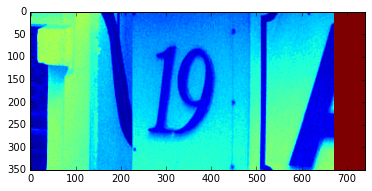

In [40]:
plt.imshow(img1)
print np.shape(img1)

In [41]:
# Use the DigitStructFile class from github.com/hangyao
# The DigitStructFile is just a wrapper around the h5py data.  It basically references 
#    inf:              The input h5 matlab file
#    digitStructName   The h5 ref to all the file names
#    digitStructBbox   The h5 ref to all struc data
class DigitStructFile:
    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']

# getName returns the 'name' string for for the n(th) digitStruct. 
    def getName(self,n):
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])

# bboxHelper handles the coding difference when there is exactly one bbox or an array of bbox. 
    def bboxHelper(self,attr):
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

# getBbox returns a dict of data for the n(th) bbox. 
    def getBbox(self,n):
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.bboxHelper(self.inf[bb]["height"])
        bbox['label'] = self.bboxHelper(self.inf[bb]["label"])
        bbox['left'] = self.bboxHelper(self.inf[bb]["left"])
        bbox['top'] = self.bboxHelper(self.inf[bb]["top"])
        bbox['width'] = self.bboxHelper(self.inf[bb]["width"])
        return bbox

    def getDigitStructure(self,n):
        s = self.getBbox(n)
        s['name']=self.getName(n)
        return s

# getAllDigitStructure returns all the digitStruct from the input file.     
    def getAllDigitStructure(self):
        return [self.getDigitStructure(i) for i in range(len(self.digitStructName))]

# Return a restructured version of the dataset (one structure by boxed digit).
#
#   Return a list of such dicts :
#      'filename' : filename of the samples
#      'boxes' : list of such dicts (one by digit) :
#          'label' : 1 to 9 corresponding digits. 10 for digit '0' in image.
#          'left', 'top' : position of bounding box
#          'width', 'height' : dimension of bounding box
#
# Note: We may turn this to a generator, if memory issues arise.
    def getAllDigitStructure_ByDigit(self):
        pictDat = self.getAllDigitStructure()
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            item = { 'filename' : pictDat[i]["name"] }
            figures = []
            for j in range(len(pictDat[i]['height'])):
               figure = {}
               figure['height'] = pictDat[i]['height'][j]
               figure['label']  = pictDat[i]['label'][j]
               figure['left']   = pictDat[i]['left'][j]
               figure['top']    = pictDat[i]['top'][j]
               figure['width']  = pictDat[i]['width'][j]
               figures.append(figure)
            structCnt = structCnt + 1
            item['boxes'] = figures
            result.append(item)
        return result

In [42]:
train_digitstruct = DigitStructFile(train_struct_loc)

In [44]:
train1_dict = train_digitstruct.getDigitStructure(0)
print train1_dict

{'name': '1.png', 'top': [77.0, 81.0], 'label': [1.0, 9.0], 'width': [81.0, 96.0], 'height': [219.0, 219.0], 'left': [246.0, 323.0]}


In [49]:
# Now, lets mess with the 1 image to crop to the bounding box.
min_top1 = int(np.min(train1_dict['top']))
top1 = int(min_top1 - np.ceil(0.1*min_top1))
min_left1 = int(np.min(train1_dict['left']))
left1 = int(min_left1 - np.ceil(0.1*min_left1))
total_height1 = int(np.max(train1_dict['height']))
height1 = int(total_height1 + np.ceil(0.05*total_height1))
total_width1 = int(np.sum(train1_dict['width']))
width1 = int(total_width1 + np.ceil(0.15*total_width1))
bottom1 = min_top1 + total_height1
right1 = min_left1 + total_width1
print [min_top1, min_left1, total_height1, total_width1]
print [top1, left1, height1, width1]

[77, 246, 219, 177]
[69, 221, 230, 204]


In [50]:
# img1_crop = img1[min_top1:bottom1,min_left1:right1]
img1_crop = img1[top1:(top1 + height1),left1:(left1 + width1)]

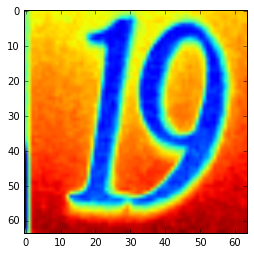

In [51]:
img1_rs = misc.imresize(img1_crop, (64,64))
plt.imshow(img1_rs)

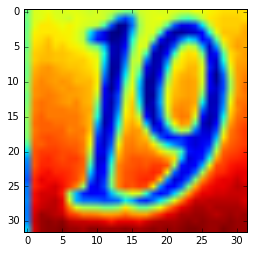

In [52]:
# Compare against the 32x32. 64x64 does not look terrible, but it may introduce more error.
img1_rs = misc.imresize(img1_crop, (32,32))
plt.imshow(img1_rs)

The following code reads the images and crops according to the steps above. Then it encodes the label for each of these pieces of data.

In [57]:
MAX_LENGTH = 5
crop_size = 64
enc = skproc.OneHotEncoder(n_values=11,sparse=False)
for i in range(1,100):
    # for train_dict in train_digitstruct.getAllDigitStructure():
    # Load the image and crop, resize to 32x32
    train_dict = train_digitstruct.getDigitStructure(i)
    curr_img = img.imread(img_loc_root + train_dict['name'],mode='L')
    img_shape = np.shape(curr_img)
    bb_top = np.min(train_dict['top'])
    bb_left = np.min(train_dict['left'])
    bb_height = np.max(train_dict['height'])
    bb_twidth = np.sum(train_dict['width'])
    # Add some pixel buffer before cropping.
    min_top = int( bb_top - 0.1*bb_top )
    min_left = int( bb_left - 0.1*bb_left )
    # ... a little less on the height
    total_height = int( bb_height + 0.05*bb_height )
    total_width = int( bb_twidth + 0.1*bb_twidth )
    curr_img_crop = curr_img[min_top:min_top+total_height,min_left:min_left+total_width]
    img_rs = misc.imresize(curr_img_crop, (32,32))
#     plt.imshow(img_rs)
    
    # Build the label data with one hot encoding.
    street_label = np.array(train_dict['label']).astype(int)
    # Replace any instances of 10 with 0 - needed for one-hot encoding.
    street_label[street_label == 10] = 0
    curr_len = np.shape(street_label)[0]
    len_onehot = enc.fit_transform(curr_len)
#     print "Length = " + str(curr_len) + " Street Label = " + str(street_label)
    y_onehot = np.concatenate((len_onehot, enc.fit_transform(street_label.reshape(-1,1))),axis=0)
    # Create the padding for MAX_LENGTH - curr_len
    nodigit_padding = np.array([10 for i in range(MAX_LENGTH-curr_len)])
    padding_onehot = enc.fit_transform(nodigit_padding.reshape(-1,1))
    y_onehot = np.concatenate((y_onehot, padding_onehot), axis=0)
    if np.any(street_label == 0):
        print (curr_len, street_label)
        print y_onehot    

(3, array([6, 0, 1]))
[[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]
(2, array([2, 0]))
[[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]
(3, array([2, 0, 4]))
[[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]
(2, array([1, 0]))
[[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0. 